# Monte Carlo Prediction

We run several episodes with a policy, collecting hundreds of trajectories and then estimate the expectation using the empirical mean.

We need a function to run a policy over an environment and to extract the collection of experience tuples (trajectory)

In [14]:
from itertools import count

def generate_trajectory(pi, env, max_steps=200):
    
    # initialize the done flag and a list of experiences (trajectory)
    done, trajectory = False, []
    
    # looping through until the done flag is set to true
    while not done:
        
        # reset the environment to interact in a new episode
        state = env.reset()
        
        # start counting steps t
        for t in count():
            
            # use the policy function to pick an action
            action = pi(state) 
            
            # step the environment using that action and 
            # obtain the full experience tuple
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            
            # append the experience to the trajectory
            trajectory.append(experience)
            
            # if we hit a terminal state break and return
            if done:
                break
                
            # this allows to truncate long trajectories, if desired
            # if the count of steps hits the maximum allowed, 
            # we clear the trajectory, break, and try to obtain another trajectory
            if t >= max_steps - 1:
                trajectory = []
                break
            
            # update the state
            state = next_state
            
    # Finally, we return a NumPy version of
    # the trajectory for easy data manipulation
    return np.array(trajectory, object)

The hyperparameter alpha is essential. Often, alpha is a positive constant less than 1. Having a constant alpha helps with learning in non-stationary environments. However, we can decay alpha in order to show convergence.

In [15]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    # calculate the number of steps to decay the values, this is the index 
    # where the decaying of values terminates and the min_value continues 
    # until max_steps.
    decay_steps = int(max_steps * decay_ratio)
    
    # the remaining steps (the difference)
    rem_steps = max_steps - decay_steps
    
    # calculare the actual values using the logspace starting from 
    # log_start (default -2) and ending on 0. 
    # The number of values in that space is decay_steps and the base is 
    # log_base (default 10). Notice, the values are reversed 
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # just repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

We use this schedule for the learning rate, alpha, in all algorithms: alpha starts at 0.5, and it decreases exponentially to 0.01 in 250 episodes out of the 500 total episodes. 

In that way alpha helps the algorithms get close to converging, but because alpha don't goes to zero, they don’t fully converge. Other than that, these results should help us gain some intuition about the differences between different methods.

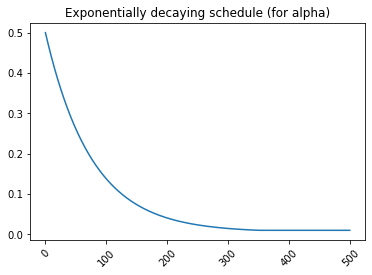

In [16]:
import matplotlib.pyplot as plt
plt.plot(decay_schedule(0.5, 0.01, 0.7, 500))
plt.title('Exponentially decaying schedule (for alpha)')
plt.xticks(rotation=45)
plt.show()

We write the prediction function that works for First-Visit-Monte-Carlo:

In [17]:
def mc(pi, env, gamma=1.0,
       init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
       n_episodes=500, max_steps=200):
    
    nS = env.observation_space.n
    
    # calculate all discounts at once. 
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    
    # initialize the current estimate of the state-value function V
    # and a per-episode copy of V for offline analysis
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    # loop for every episode 
    for e in range(n_episodes):
        
        # generate a trajectory
        trajectory = generate_trajectory(pi, env, max_steps)
        
        # initialize a visits check vector
        visited = np.zeros(nS, dtype=bool)
        
        # now loop through all experiences in the trajectory
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            
            # check if the state has already been visited on 
            # this trajectory (FVMC), if so, we process the next state
            if visited[state]: continue
            visited[state] = True
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:])
            
            # calculate the return
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            
            # estimate the value function
            V[state] = V[state] + alphas[e] * (G - V[state])
        
            # keep track of the episode’s V
            V_track[e] = V
            
    return V.copy(), V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [18]:
class Space:
    def __init__(self, value):
        self.n = value 
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(7)
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        self._state += np.random.choice([-1, 1])
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [19]:
env = RandomWalk()

We evaluate an "all-left" policy

In [20]:
def pi(state):
    return 1

We use the Monte Carlo prediction algorithm and show the estimates over episodes

In [21]:
V_mc, V_mc_track = mc(pi, env, n_episodes=500);

In [23]:
print(V_mc)

[0.         0.19450983 0.35825966 0.52812128 0.69455657 0.84856013
 0.        ]


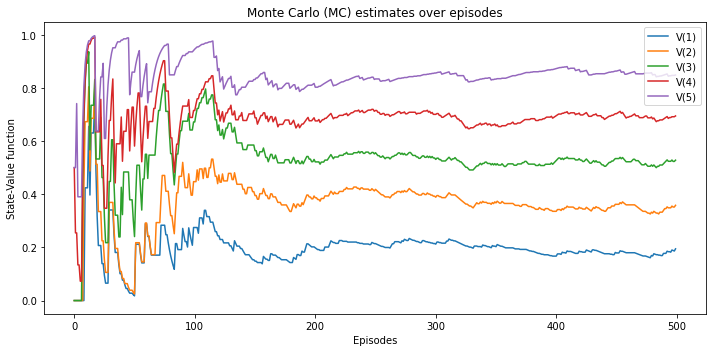

In [24]:
plt.figure(figsize=(10,5))
legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.plot(V_mc_track[:,1:6])
plt.title('Monte Carlo (MC) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()